# HHL を利用して線形方程式系を解きQiskit で実装する

このチュートリアルでは、HHL アルゴリズムを紹介したあと量子回路を導出し、Qiskit を利用して実装します。HHL をどのようにシミュレーターと５量子ビットデバイスで実行するかも示します。

## 内容
1. [はじめに](#introduction)
2. [HHLアルゴリズム](#hhlalg)
    1. [いくつかの数学的背景](#mathbackground)
    2. [HHL アルゴリムの説明](#hhldescription)
    3. [HHLでの量子位相推定(QPE) について](#qpe)
    4. [正確でない QPE の場合](#qpe2)
3. [例: 4量子ビット HHL](#example1)
4. [Qiskit実装](#implementation)
    1. [HHL をシミュレーターで実行する: 一般的な方法](#implementationsim)
    2. [HHL を実量子デバイスで実行する：最適化例](#implementationdev)
5. [演習](#problems)
6. [参考文献](#references)

## 1. はじめに <a id='introduction'></a>

線形方程式系は様々な分野で、多くの実世界アプリケーションとして自然に現れます。例えば、偏微分方程式の解、金融モデルの校正（キャリブレーション)、流体シミュレーション、あるいは数値場計算などです。問題は次のように定義できます：行列　
$A\in\mathbb{C}^{N\times N}$ とベクトル $\vec{b}\in\mathbb{C}^{N}$ が与えられている時、 $A\vec{x}=\vec{b}　$　を満足する $\vec{x}\in\mathbb{C}^{N} $ を求める。

$N=2$ の場合に以下の例を見てみましょう。

$$A = \begin{pmatrix}1 & -1/3\\-1/3 & 1 \end{pmatrix},\quad \vec{x}=\begin{pmatrix} x_{1}\\ x_{2}\end{pmatrix}\quad , \quad \vec{b}=\begin{pmatrix}1 \\ 0\end{pmatrix}.$$

この問題は以下のように $x_{1}, x_{2}\in\mathbb{C}$ を見つけるというものに書き換えることもできます。

$$\begin{cases}x_{1} - \frac{x_{2}}{3} = 1 \\ -\frac{x_{1}}{3} + x_{2} = 0\end{cases}. $$

線形方程式系は$A$の行もしくは列に高々$s$個の非ゼロ成分を持つ時に、$s$-sparse (スパース、疎行列)と呼ばれます。$N$ サイズの $s$-sparse系を古典コンピューターで解くには、共役勾配法(conjugate gradient method) を用いても $\mathcal{ O }(Ns\kappa\log(1/\epsilon))$ の実行時間が必要です <sup>[1](#conjgrad)</sup>。ここで、$\kappa$ はシステムの条件数、$\epsilon$ は近似の正確度です。

HHLは、データのローディングを実施する効果的なオラクル(Oracle)が存在し、ハミルトニアン シミュレーションと解の関数の計算が可能であるという仮定のもとで、$A$ がエルミート行列である時、複雑な式 $\mathcal{ O }(\log(N)s^{2}\kappa^{2}/\epsilon)$<sup>[2](#hhl)</sup> に比例した時間で解の関数を推測するという量子アルゴリズムです。これはシステムのサイズに対して指数関数的スピードアップです。ただし、非常に重要な注意点があり、古典アルゴリズムが完全解を返すのに対して、HHL は解となるベクトルを与える関数を近似するだけです。

## 2. HHLアルゴリズム<a id='hhlalg'></a>

### A. いくつかの数学的背景<a id='mathbackground'></a>
量子コンピューターを利用して線形方程式系を解く最初のステップは、問題を量子の言葉に落とし込むことです。系を再スケールすることで、$\vec{b}$ と $\vec{x}$ は正規化できると仮定でき、それぞれ量子状態 $|b\rangle$ と $|x\rangle$ にマップできます。通常、利用されるマッピングは次のようなものです。すなわち、$\vec{b}$ (resp. $\vec{x}$) の $i$ 番目の成分は、量子状態 $|b\rangle$ (resp. $|x\rangle$) の $i$番目の基底状態の振幅に対応するというものです。ここからは、再スケールされた問題にフォーカスします。

$$ A|x\rangle=|b\rangle.$$

$A$ はエルミートなので、スペクトル分解を持ちます。

$$
A=\sum_{j=0}^{N-1}\lambda_{j}|u_{j}\rangle\langle u_{j}|,\quad \lambda_{j}\in\mathbb{ R },
$$

ここで、$|u_{j}\rangle$ は $A$ の $j$ 番目の固有ベクトルで、固有値 はそれぞれ $\lambda_{j}$ です。次に、逆行列です。

$$
A^{-1}=\sum_{j=0}^{N-1}\lambda_{j}^{-1}|u_{j}\rangle\langle u_{j}|,
$$

系の右側は $A$ の固有基底を用いて次のように書けます。
$$
|b\rangle=\sum_{j=0}^{N-1}b_{j}|u_{j}\rangle,\quad b_{j}\in\mathbb{ C }.
$$

HHLの目的は、次の状態でレジスターを読み込むことでアルゴリズムを終了させることを銘記してください。
$$
|x\rangle=A^{-1}|b\rangle=\sum_{j=0}^{N-1}\lambda_{j}^{-1}b_{j}|u_{j}\rangle.
$$
量子状態について話しているので、既に暗黙的な規格化定数が入っていることに着目してください。

### B. HHL アルゴリムの説明 <a id='hhldescription'></a>

アルゴリズムは３つの量子レジスターを利用し、アルゴリズムの開始時点ではすべて $|0\rangle $ にセットされます。一つのレジスター(ここでは $n_{l}$ とサブインデックスで示します)は $A$ の固有値のバイナリー表現の保管に利用されます。２つ目のレジスター、$n_{b}$はベクトル解が保管されます。ここからは $N=2^{n_{b}}$ とします。補助量子ビットとして追加のレジスターがあります。追加レジスターは、個々の計算の中間段階で利用されますが、各計算の最初に $|0\rangle $ にセットされ、個々の操作の最後には、$|0\rangle $ 状態に戻されるため、以下の説明では省略しています。

以下の手順で対応する回路のハイレベルな図形で HHL アルゴリズムのアウトラインを説明します。簡単のため、引き続く説明ではすべての計算が正確であると仮定し、正確でない場合の詳細なセクション [2.D.](#qpe2) で説明します。

<img src="images/hhlcircuit.png" width = "75%" height = "75%">

1. データ $|b\rangle\in\mathbb{ C }^{N}$ のロード。すなわち、以下の変換を実行します。
    $$ |0\rangle _{n_{b}} \mapsto |b\rangle _{n_{b}}. $$
2. 量子位相推定(Quantum Phase Estimation - QPE) を適用します。
	$$
	U = e ^ { i A t } := \sum _{j=0}^{N-1}e ^ { i \lambda _ { j } t } |u_{j}\rangle\langle u_{j}|.
	$$
	$A$ の固有基底で表現されるレジスターの量子状態は次のようになります。
    $$
	\sum_{j=0}^{N-1} b _ { j } |\lambda _ {j }\rangle_{n_{l}} |u_{j}\rangle_{n_{b}},
	$$
    ここで、$|\lambda _ {j }\rangle_{n_{l}}$ は $\lambda _ {j }$ の $n_{l}$ ビットバイナリー表現です。
    
3.  補助量子ビットを追加し、$|\lambda_{ j }\rangle$ の条件に応じて回転を適用します。
	$$
	\sum_{j=0}^{N-1} b _ { j } |\lambda _ { j }\rangle_{n_{l}}|u_{j}\rangle_{n_{b}} \left( \sqrt { 1 - \frac { C^{2}  } { \lambda _ { j } ^ { 2 } } } |0\rangle + \frac { C } { \lambda _ { j } } |1\rangle \right),
	$$　$C$ は規格化定数です。
        
4.  QPE$^{\dagger}$ を適用します。QPE で発生しうるエラーを無視すると、次の結果になります。
	$$
	\sum_{j=0}^{N-1} b _ { j } |0\rangle_{n_{l}}|u_{j}\rangle_{n_{b}} \left( \sqrt { 1 - \frac {C^{2}  } { \lambda _ { j } ^ { 2 } } } |0\rangle + \frac { C } { \lambda _ { j } } |1\rangle \right).
	$$
    
5. 計算基底にて補助量子ビットを測定します。結果が $1$ の場合、測定後のレジスターの状態は次のようになります。
	$$
	\left( \sqrt { \frac { 1 } { \sum_{j=0}^{N-1} \left| b _ { j } \right| ^ { 2 } / \left| \lambda _ { j } \right| ^ { 2 } } } \right) \sum _{j=0}^{N-1} \frac{b _ { j }}{\lambda _ { j }} |0\rangle_{n_{l}}|u_{j}\rangle_{n_{b}},
	$$
	規格化定数を除き、解になっています。

6. オブザーバブル $M$ を適用し、$F(x):=\langle x|M|x\rangle$ を計算します。
    
### C. HHLでの量子位相推定(QPE) について <a id='qpe'></a>

量子位相推定については第３章でより詳しく説明がされていますが、HHLアルゴリズムではこの量子処理が要になっているので、ここで定義を再確認したいと思います。大雑把にいうと、固有ベクトリ $|\psi\rangle_{m}$ と 固有値 $e^{2\pi i\theta}$ をもつユニタリー $U$ が与えられた場合に  $\theta$ を求めるという量子アルゴリズムです。次のように正確に定義できます。

**定義:** $U\in\mathbb{ C }^{2^{m}\times 2^{m}}$ がユニタリーであり、$|\psi\rangle_{m}\in\mathbb{ C }^{2^{m}}$ がそれぞれ固有値 $e^{2\pi i\theta}$ を持つ固有ベクトルである時、**量子位相推定(Quantum Phase Estimation)** (省略して **QPE**) アルゴリズムは、$U$ に対応するユニタリーゲートと状態 $|0\rangle_{n}|\psi\rangle_{m}$ を入力として、状態 $|\tilde{\theta}\rangle_{n}|\psi\rangle_{m}$ を返すアルゴリズムです。

$\tilde{\theta}$ は $2^{n}\theta$ に対するバイナリー近似を示しており、$n$ の添え文字は $n$ ディジットに切り捨てられていることを示しています。
$$
\operatorname { QPE } ( U , |0\rangle_{n}|\psi\rangle_{m} ) = |\tilde{\theta}\rangle_{n}|\psi\rangle_{m}.
$$

HHLでは QPE を $U = e ^ { i A t }$ に対して適用しています。ここで $A$ は行列で解きたい系に関係しています。この場合、
$$
e ^ { i A t } = \sum_{j=0}^{N-1}e^{i\lambda_{j}t}|u_{j}\rangle\langle u_{j}|.
$$
です。さらに、固有値 $e ^ { i \lambda _ { j } t }$ をもつ固有ベクトル $|u_{j}\rangle_{n_{b}}$ に対しては QPE は $|\tilde{\lambda }_ { j }\rangle_{n_{l}}|u_{j}\rangle_{n_{b}}$ を出力します。$\tilde{\lambda }_ { j }$ は、$2^{n_l}\frac{\lambda_ { j }t}{2\pi}$ に対する $n_{l}$-bit バイナリー近似です。従って、仮にそれぞれの $\lambda_{j}$ が $n_{l}$ビットで正確に記述できる場合には、
$$
\operatorname { QPE } ( e ^ { i A 2\pi } , \sum_{j=0}^{N-1}b_{j}|0\rangle_{n_{l}}|u_{j}\rangle_{n_{b}} ) = \sum_{j=0}^{N-1}b_{j}|\lambda_{j}\rangle_{n_{l}}|u_{j}\rangle_{n_{b}}.
$$
となります。

### D. 正確でない QPE の場合<a id='qpe2'></a>

現実には、QPE を初期状態に適用したあとのレジスターの量子状態は、
$$
\sum _ { j=0 }^{N-1} b _ { j } \left( \sum _ { l = 0 } ^ { 2 ^ { n_{l} } - 1 } \alpha _ { l | j } |l\rangle_{n_{l}} \right)|u_{j}\rangle_{n_{b}},
$$
です。ここで、
$$
\alpha _ { l | j } = \frac { 1 } { 2 ^ { n_{l} } } \sum _ { k = 0 } ^ { 2^{n_{l}}- 1 } \left( e ^ { 2 \pi i \left( \frac { \lambda _ { j } t } { 2 \pi } - \frac { l } { 2 ^ { n_{l} } } \right) } \right) ^ { k }.
$$

$\tilde{\lambda_{j}}$ で表すのは、 $\lambda_{j}$, $1\leq j\leq N$ に対する ベストな $n_{l}$ビット近似です。次に、$n_{l}$-レジスターを再ラベルし、$\alpha _ { l | j }$ が $|l + \tilde { \lambda } _ { j } \rangle_{n_{l}}$ の振幅を表すようにします。そうすると、以下のように変形できます。
$$
\alpha _ { l | j } : = \frac { 1 } { 2 ^ { n_{l}} } \sum _ { k = 0 } ^ { 2 ^ { n_{l} } - 1 } \left( e ^ { 2 \pi i \left( \frac { \lambda _ { j } t } { 2 \pi } - \frac { l + \tilde { \lambda } _ { j } } { 2 ^ { n_{l} } } \right) } \right) ^ { k }.
$$
各 $\frac { \lambda _ { j } t } { 2 \pi }$ が $n_{l}$ バイナリービットで正確に表現できる場合には、$\frac { \lambda _ { j } t } { 2 \pi }=\frac { \tilde { \lambda } _ { j } } { 2 ^ { n_{l} } }$ $\forall j$ となります。従って、$\forall j$, $1\leq j \leq N$　の場合は、 $\alpha _ { 0 | j } = 1$ と $\alpha _ { l | j } = 0 \quad \forall l \neq 0$ を保持します。この場合のみ、QPE を適用した後のレジスターの状態を次のように書けます。
$$
	\sum_{j=0}^{N-1} b _ { j } |\lambda _ {j }\rangle_{n_{l}} |u_{j}\rangle_{n_{b}}.
$$
それ以外の場合は、 $|\alpha _ { l | j }|$ は $\frac { \lambda _ { j } t } { 2 \pi } \approx \frac { l + \tilde { \lambda } _ { j } } { 2 ^ { n_{l} } }$ の場合のみ大きく、レジスターの状態は次のようになります。
$$
\sum _ { j=0 }^{N-1}  \sum _ { l = 0 } ^ { 2 ^ { n_{l} } - 1 } \alpha _ { l | j } b _ { j }|l\rangle_{n_{l}} |u_{j}\rangle_{n_{b}}.
$$

## 3. 例: 4量子ビット HHL<a id='example1'></a>

はじめにのセクションで紹介した小さな例をとってアルゴリズムを説明しましょう。こうでした。
$$A = \begin{pmatrix}1 & -1/3\\-1/3 & 1 \end{pmatrix}\quad , \quad |b\rangle=\begin{pmatrix}1 \\ 0\end{pmatrix}.$$

$|b\rangle$ には $n_{b}=1$ 量子ビットを利用し、解 $|x\rangle$ には、$n_{l}=2$ 量子ビットを固有値のバイナリー表現を利用し、$1$ 補助量子ビットを制御回転に利用します。このようにするとアルゴリズムが成功します。

アルゴリズムの例示のため、少しごまかして $A$ の固有値を計算して、$n_{l}$-レジスターの再スケールされた固有値の正確なバイナリー表現を得るために、 $t$ を選択できるようにします。なお、HHL アルゴリズムの実装には固有値の事前知識は必要ないことは心に留めてください。とは言ったものの、簡単に計算すると、
$$\lambda_{1} = 2/3\quad , \quad\lambda_{2}=4/3.$$
が得られます。

前のセクションを思い出すと、 QPE は $\frac{\lambda_ { j }t}{2\pi}$ に対する $n_{l}$ビット (この例では $2$ビット) バイナリー近似を出力するものでした。従って、 
$$t=2\pi\cdot \frac{3}{8},$$
を設定すると、QPE は
$$\frac{\lambda_ { 1 }t}{2\pi} = 1/4\quad , \quad\frac{\lambda_ { 2 }t}{2\pi}=1/2,$$
への$2$ビットバイナリー近似を与えます。これらはそれぞれ、
$$|01\rangle_{n_{l}}\quad , \quad|10\rangle_{n_{l}}.$$
に対応します。

固有ベクトルはそれぞれ、
$$|u_{1}\rangle=\begin{pmatrix}1 \\ -1\end{pmatrix}\quad , \quad|u_{2}\rangle=\begin{pmatrix}1 \\ 1\end{pmatrix}.$$
再度、HHL の実装には固有ベクトルの計算は必要ないことを心に銘記してください。事実、$N$ 次元の一般的なエルミート行列 $A$ は $N$ 個の異なる固有値を持つことがあり、従って計算には $\mathcal{O}(N)$ 時間かかるので、量子アドバンテージが失われてしまいます。

次に、$A$ の固有基底で $|b\rangle$ が次のように書けます。
$$|b\rangle _{n_{b}}=\sum_{j=0}^{N-1}\frac{1}{\sqrt{2}}|u_{j}\rangle _{n_{b}}.$$

ここで、HHL アルゴリズムを適用する準備が整いましたので、ひとつひとつ見ていきます。

1. この例における初期状態準備は簡単です。 $|b\rangle=|0\rangle$。
2. QPE を適用します。
$$
\frac{1}{\sqrt{2}}|01\rangle|u_{1}\rangle + \frac{1}{\sqrt{2}}|10\rangle|u_{2}\rangle.
$$
3. 固有値を再スケールした結果を補うため $C=3/8$ で制御回転させます。
$$\frac{1}{\sqrt{2}}|01\rangle|u_{1}\rangle\left( \sqrt { 1 - \frac { (3/8)^{2}  } {(1/4)^{2} } } |0\rangle + \frac { 3/8 } { 1/4 } |1\rangle \right) + \frac{1}{\sqrt{2}}|10\rangle|u_{2}\rangle\left( \sqrt { 1 - \frac { (3/8)^{2}  } {(1/2)^{2} } } |0\rangle + \frac { 3/8 } { 1/2 } |1\rangle \right)
$$
$$
=\frac{1}{\sqrt{2}}|01\rangle|u_{1}\rangle\left( \sqrt { 1 - \frac { 9  } {4 } } |0\rangle + \frac { 3 } { 2 } |1\rangle \right) + \frac{1}{\sqrt{2}}|10\rangle|u_{2}\rangle\left( \sqrt { 1 - \frac { 9  } {16 } } |0\rangle + \frac { 3 } { 4 } |1\rangle \right).
$$
4. QPE$^{\dagger}$ を量子コンピューターで適用した後は、次の状態になります。
$$
\frac{1}{\sqrt{2}}|00\rangle|u_{1}\rangle\left( \sqrt { 1 - \frac { 9  } {4 } } |0\rangle + \frac { 3 } { 2 } |1\rangle \right) + \frac{1}{\sqrt{2}}|00\rangle|u_{2}\rangle\left( \sqrt { 1 - \frac { 9  } {16 } } |0\rangle + \frac { 3 } { 4 } |1\rangle \right).
$$
5. 補助ビットを計測し、$1$ が出た場合には状態は次のようになります。
$$
\frac{\frac{1}{\sqrt{2}}|00\rangle|u_{1}\rangle\frac { 3 } { 2 } |1\rangle + \frac{1}{\sqrt{2}}|00\rangle|u_{2}\rangle\frac { 3 } { 4 } |1\rangle}{\sqrt{45/32}}.
$$
簡単に計算すると：
$$
\frac{\frac{3}{2\sqrt{2}}|u_{1}\rangle+ \frac{3}{4\sqrt{2}}|u_{2}\rangle}{\sqrt{45/32}} = \frac{|x\rangle}{||x||}.
$$
6. 追加のゲートを利用しなくても、$|x\rangle$ のノルムを計算できます、それは前のステップで補助ビットを $1$ で測定する確率になります。
$$
P[|1\rangle] = \left(\frac{3}{2\sqrt{2}}\right)^{2} + \left(\frac{3}{4\sqrt{2}}\right)^{2} = \frac{45}{32} = |||x\rangle||^{2}.
$$



## 4. Qiskit 実装<a id='implementation'></a>

例を利用して問題を分析的に解きましたが、HHL を量子シミュレーターと実ハードウェアで実行することを示したいと思います。量子シミュレーターの場合は、Qiskit Aqua に行列$A$ と $|b\rangle$ を基本入力として要求する HHL アルゴリズム実装が既に提供されています。主なアドバンテージは一般的なエルミート行列と任意の初期状態を入力することができる点です。これが意味することは、このアルゴリズムは一般の目的のために設計されており、特定の問題のための回路の最適化は実施しないということです。そのため、既存の実ハードウェアで実行することが目的の場合には問題が生じます。この章を記述している時点で、既存の量子コンピューターはノイズがあり、小さな回路しか実行できません。そのため、セクション[4.B.](#implementationdev)では、この例が帰属する問題のクラスに利用できる最適化された回路を見ることにし、ノイズのある量子コンピューターに対する既存の処理方法について述べます。

## A. HHL をシミュレーターで実行する: 一般的な方法<a id='implementationsim'></a>

Qiskit Aqua が提供する HHL アルゴリズムを実行するには、適切なモジュールをインポートし以下のようにパラメータをセットするだけです。いままで見てきた例では、ハミルトニアンシミュレーションの時間を $t=2\pi\cdot \frac{3}{8}$ にセットしましたが、固有値の知識が必要ないことを示すためこのパラメータをセットしないでシミュレーションを実行してみます。それにも関わらず、行列がある構造がある場合には、固有値情報を得て適切な $t$ を選択し HHLが返す解の精度を向上させることができるかも知れません。8の演習で、$t=2\pi\cdot \frac{3}{8}$ をセットし正常に実行されると解のフィデリティーは $1$ になることを確認します。

In [1]:
from qiskit import Aer
from qiskit.circuit.library import QFT
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.quantum_info import state_fidelity
from qiskit.aqua.algorithms import HHL, NumPyLSsolver
from qiskit.aqua.components.eigs import EigsQPE
from qiskit.aqua.components.reciprocals import LookupRotation
from qiskit.aqua.operators import MatrixOperator
from qiskit.aqua.components.initial_states import Custom
import numpy as np

In [2]:
def create_eigs(matrix, num_ancillae, num_time_slices, negative_evals):
    ne_qfts = [None, None]
    if negative_evals:
        num_ancillae += 1
        ne_qfts = [QFT(num_ancillae - 1), QFT(num_ancillae - 1).inverse()]

    return EigsQPE(MatrixOperator(matrix=matrix),
                   QFT(num_ancillae).inverse(),
                   num_time_slices=num_time_slices,
                   num_ancillae=num_ancillae,
                   expansion_mode='suzuki',
                   expansion_order=2,
                   evo_time=None,  # This is t, can set to: np.pi*3/4
                   negative_evals=negative_evals,
                   ne_qfts=ne_qfts)

次の関数を使って HHL アルゴリズムが返した解のフィデリティーを計算します。


In [3]:
def fidelity(hhl, ref):
    solution_hhl_normed = hhl / np.linalg.norm(hhl)
    solution_ref_normed = ref / np.linalg.norm(ref)
    fidelity = state_fidelity(solution_hhl_normed, solution_ref_normed)
    print("Fidelity:\t\t %f" % fidelity)

In [4]:
matrix = [[1, -1/3], [-1/3, 1]]
vector = [1, 0]

In [5]:
orig_size = len(vector)
matrix, vector, truncate_powerdim, truncate_hermitian = HHL.matrix_resize(matrix, vector)

# Initialize eigenvalue finding module
eigs = create_eigs(matrix, 3, 50, False)
num_q, num_a = eigs.get_register_sizes()

# Initialize initial state module
init_state = Custom(num_q, state_vector=vector)

# Initialize reciprocal rotation module
reci = LookupRotation(negative_evals=eigs._negative_evals, evo_time=eigs._evo_time)

algo = HHL(matrix, vector, truncate_powerdim, truncate_hermitian, eigs,
           init_state, reci, num_q, num_a, orig_size)


$t=2\pi\cdot \frac{3}{8}$ を選択した理由は固有値を再スケールさせるためでした。今はこの場合に当てはまらないので、表現は近似になり、QPE は非正確で結果の解も近似になります。

In [6]:
result = algo.run(QuantumInstance(Aer.get_backend('statevector_simulator')))
print("Solution:\t\t", np.round(result['solution'], 5))

result_ref = NumPyLSsolver(matrix, vector).run()
print("Classical Solution:\t", np.round(result_ref['solution'], 5))

print("Probability:\t\t %f" % result['probability_result'])
fidelity(result['solution'], result_ref['solution'])

Solution:		 [1.13586-0.j 0.40896+0.j]
Classical Solution:	 [1.125 0.375]
Probability:		 0.056291
Fidelity:		 0.999432


アルゴリズムは利用したリソースを出力します。depth は単一量子ビットに適用されたゲート数の最大値で、width は利用した量子ビットの数として定義されます。また、CNOT の数も出力してみます。この数をもちいて、実行している回路が現在の実ハードウェアで実行することができるかを判断することができます。

In [7]:
print("circuit_width:\t", result['circuit_info']['width'])
print("circuit_depth:\t", result['circuit_info']['depth'])
print("CNOT gates:\t", result['circuit_info']['operations']['cx'])

circuit_width:	 7
circuit_depth:	 102
CNOT gates:	 54


## B. HHL を実量子デバイスで実行する：最適化例<a id='implementationdev'></a>

前のセクションでは Qiskit が提供する標準のアルゴリズムを実行し、$7$ 量子ビットを利用し、depth が $102$ ゲートで、かつ $54$ CNOTゲートを利用しているのを見ました。この数は現在利用可能なハードウェアで実行するには不適切で、量を減らす必要があります。特にゴールは単一量子ゲートに比べフィデリティーが悪化する CNOTの数を $10$ のファクターで減らすことです。さらに量子ビットの数を $4$ にします。これはもともとの問題での数です。Qiskit の方法は一般的な問題のために書かれているため、余分な $3$ 補助量子ビットが追加されました。

ところが、単純にゲートや量子ビットの数を減らすだけでは実ハードウェア上の解としてよい近似が出てきません。二つのエラーソースが原因です：実行時に発生するものと読み取りエラーです。

Qiskit には、個別に全ての基底状態を準備測定することで読み取りエラーを回避するモジュールが提供されています。このトピックの詳細は  Dewes et al.<sup>[3](#readouterr)</sup> を参照してください。回路の実行時に発生するエラーを取り扱うために、回路を３回実行し、それぞれ CNOTゲートを $1$, $3$, $5$ CNOT で置き換えるという Richardson 外挿を利用します<sup>[4](#richardson)</sup>。

理論的には３つの回路は同じ結果をもたらしますが、実ハードウェアでは CNOT を追加するということはエラーを増幅することになるというアイデアに基づきます。得られた結果がエラーが増幅したことによるということを知るので、それぞれの場合でどの程度エラーが増幅したのかを推定できます。これらの量を組み合わせることで、前の詳細な値よりも解析解により近い近似値をだすあたらしい結果を得ることができます。

以下はどのようなフォームの問題でも利用できる最適化された回路です。
$$A = \begin{pmatrix}a & b\\b & a \end{pmatrix}\quad , \quad |b\rangle=\begin{pmatrix}\cos(\theta) \\ \sin(\theta)\end{pmatrix},\quad a,b,\theta\in\mathbb{R}.$$

以下の最適化は HHL for tridiagonal symmetric matrices<sup>[5](#tridi)</sup> での結果から引用したもので、特に回路は UniversalQCompiler software<sup>[6](#qcompiler)</sup> の助けを借りて導出しました。

Depth: 26
CNOTS: 10


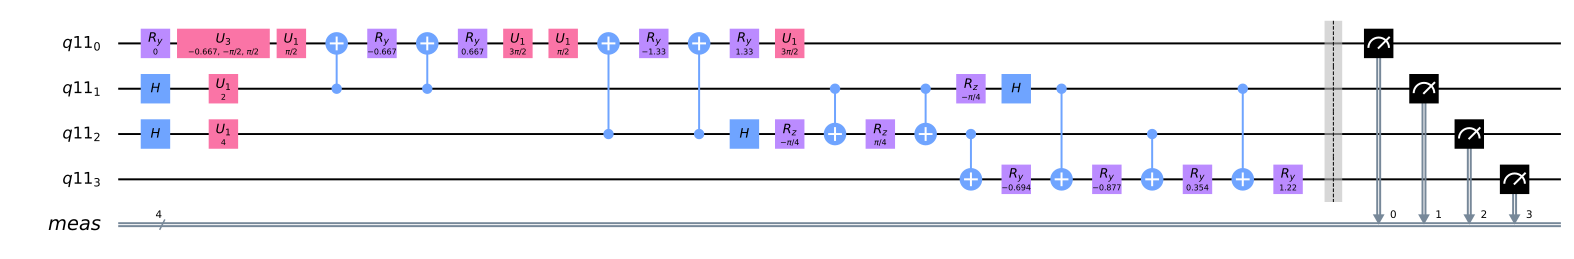

In [8]:
from qiskit import QuantumRegister, QuantumCircuit
import numpy as np

t = 2  # This is not optimal; As an exercise, set this to the
       # value that will get the best results. See section 8 for solution.

nqubits = 4  # Total number of qubits
nb = 1  # Number of qubits representing the solution
nl = 2  # Number of qubits representing the eigenvalues

theta = 0  # Angle defining |b>

a = 1  # Matrix diagonal
b = -1/3  # Matrix off-diagonal

# Initialise the quantum and classical registers
qr = QuantumRegister(nqubits)

# Create a Quantum Circuit
qc = QuantumCircuit(qr)

qrb = qr[0:nb]
qrl = qr[nb:nb+nl]
qra = qr[nb+nl:nb+nl+1]

# State preparation. 
qc.ry(2*theta, qrb[0])
    
# QPE with e^{iAt}
for qu in qrl:
    qc.h(qu)

qc.u1(a*t, qrl[0])
qc.u1(a*t*2, qrl[1])

qc.u3(b*t, -np.pi/2, np.pi/2, qrb[0])


# Controlled e^{iAt} on \lambda_{1}:
params=b*t

qc.u1(np.pi/2,qrb[0])
qc.cx(qrl[0],qrb[0])
qc.ry(params,qrb[0])
qc.cx(qrl[0],qrb[0])
qc.ry(-params,qrb[0])
qc.u1(3*np.pi/2,qrb[0])

# Controlled e^{2iAt} on \lambda_{2}:
params = b*t*2

qc.u1(np.pi/2,qrb[0])
qc.cx(qrl[1],qrb[0])
qc.ry(params,qrb[0])
qc.cx(qrl[1],qrb[0])
qc.ry(-params,qrb[0])
qc.u1(3*np.pi/2,qrb[0])

# Inverse QFT
qc.h(qrl[1])
qc.rz(-np.pi/4,qrl[1])
qc.cx(qrl[0],qrl[1])
qc.rz(np.pi/4,qrl[1])
qc.cx(qrl[0],qrl[1])
qc.rz(-np.pi/4,qrl[0])
qc.h(qrl[0])

# Eigenvalue rotation
t1=(-np.pi +np.pi/3 - 2*np.arcsin(1/3))/4
t2=(-np.pi -np.pi/3 + 2*np.arcsin(1/3))/4
t3=(np.pi -np.pi/3 - 2*np.arcsin(1/3))/4
t4=(np.pi +np.pi/3 + 2*np.arcsin(1/3))/4

qc.cx(qrl[1],qra[0])
qc.ry(t1,qra[0])
qc.cx(qrl[0],qra[0])
qc.ry(t2,qra[0])
qc.cx(qrl[1],qra[0])
qc.ry(t3,qra[0])
qc.cx(qrl[0],qra[0])
qc.ry(t4,qra[0])
qc.measure_all()

print("Depth: %i" % qc.depth())
print("CNOTS: %i" % qc.count_ops()['cx'])
qc.draw(fold=100)

以下のコードでは回路、実ハードウェアのバックエンド、及び利用したい量子ビットのセットを入力とし、特定のデバイスで実行した結果とインスタンス情報を出力します。

実デバイスは定期的にキャリブレーションが必要なため、時間によっては特定の量子ビットもしくはゲートのフィデリティーが異なります。さらには、異なるチップは異なる接続性を持ちます。特定のデバイスで接続されていない２つの量子ビットゲートを実行する時には、トランスパイラーは SWAP を追加します。ですので、実行する前に、特定の時間で正しい接続性をもつかエラー率が低いかを IBM Q Experience Webページ<sup>[7](#qexperience)</sup> で確認することを推奨します。

In [9]:
from qiskit import execute, BasicAer, ClassicalRegister, IBMQ
from qiskit.compiler import transpile
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, # Measurement error mitigation functions
                                                 CompleteMeasFitter, 
                                                 MeasurementFilter)

provider = IBMQ.load_account()

backend = provider.get_backend('ibmqx2') # calibrate using real hardware
layout = [2,3,0,4]
chip_qubits = 5

# Transpiled circuit for the real hardware
qc_qa_cx = transpile(qc, backend=backend, initial_layout=layout)

次のステップでは読み取りエラーを回避するための回路を追加しています<sup>[3](#readouterr)</sup>。

In [10]:
meas_cals, state_labels = complete_meas_cal(qubit_list=layout, qr=QuantumRegister(chip_qubits))
qcs = meas_cals + [qc_qa_cx]

shots = 10
job = execute(qcs, backend=backend, shots=shots, optimization_level=0)

次のプロットは <sup>[5](#tridi)</sup> 上記の回路を $10$ の異なる初期状態から実行して得られた結果を示しています。$x$軸は各々の場合の初期状態で定義される $\theta$ 角です。結果は読み取りエラーを回避、$1$, $3$, $5$ の回路結果から得られたエラーを外挿した後の結果を表示しています。 

<img src="images/norm_public.png">

以下はエラー回避や CNOT からの外挿がない場合の比較です <sup>[5](#tridi)</sup>。

<img src="images/noerrmit_public.png">

## 8. 演習<a id='problems'></a>

1.  'evo_time': $2\pi(3/8)$ でシミュレーションを実行する。フィデリティーが $1$ となることを確認せよ。

    ##### 実ハードウェア:
2. 最適化された例で時間のパラメータをセットする。

<details>
    <summary> 解 (Click to expand)</summary>
    t = 2.344915690192344
ベストな結果はこの値をセットします。逆数は解に対して大きな貢献をするので、最小の固有値が表現できるようになります。
</details>

2. 与えられた回路で $3$ と $5$ CNOTs を実行する。回路を作成する時には引き続く CNOT ゲートが transpile() メソッドでキャンセルされないようにバリアを追加する必要がある。
3. 実ハードウェアで回路を実行し、結果に対して２次フィットを適用し外挿の値を求めよ。

## 9. 参考文献<a id='references'></a>

1. J. R. Shewchuk. An Introduction to the Conjugate Gradient Method Without the Agonizing Pain. Technical Report CMU-CS-94-125, School of Computer Science, Carnegie Mellon University, Pittsburgh, Pennsylvania, March 1994.<a id='conjgrad'></a> 
2. A. W. Harrow, A. Hassidim, and S. Lloyd, “Quantum algorithm for linear systems of equations,” Phys. Rev. Lett. 103.15 (2009), p. 150502.<a id='hhl'></a>
3. A. Dewes, F. R. Ong, V. Schmitt, R. Lauro, N. Boulant, P. Bertet, D. Vion, and D. Esteve, “Characterization of a two-transmon processor with individual single-shot qubit readout,” Phys. Rev. Lett. 108, 057002 (2012). <a id='readouterr'></a>
4. N. Stamatopoulos, D. J. Egger, Y. Sun, C. Zoufal, R. Iten, N. Shen, and S. Woerner, “Option Pricing using Quantum Computers,” arXiv:1905.02666 . <a id='richardson'></a>
5. A. Carrera Vazquez, A. Frisch, D. Steenken, H. S. Barowski, R. Hiptmair, and S. Woerner, “Enhancing Quantum Linear System Algorithm by Richardson Extrapolation,” (to be included).<a id='tridi'></a>
6. R. Iten, O. Reardon-Smith, L. Mondada, E. Redmond, R. Singh Kohli, R. Colbeck, “Introduction to UniversalQCompiler,” arXiv:1904.01072 .<a id='qcompiler'></a>
7. https://quantum-computing.ibm.com/ .<a id='qexperience'></a>
8. D. Bucher, J. Mueggenburg, G. Kus, I. Haide, S. Deutschle, H. Barowski, D. Steenken, A. Frisch, "Qiskit Aqua: Solving linear systems of equations with the HHL algorithm" https://github.com/Qiskit/qiskit-tutorials/blob/master/legacy_tutorials/aqua/linear_systems_of_equations.ipynb